# Clone the git repo

In [1]:
from getpass import getpass

# Securely ask for GitHub token
token = getpass("Enter your GitHub token: ")
!git clone https://{token}@github.com/SRINIRAGZ/sentimentAnalysis.git

Enter your GitHub token: ··········
Cloning into 'sentimentAnalysis'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 52 (delta 23), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 1.08 MiB | 2.89 MiB/s, done.
Resolving deltas: 100% (23/23), done.


# Installation of libraries

In [2]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# Code

In [3]:
import numpy as np
import os
import pandas as pd
import re


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: /content


## Configs

In [4]:
filename = 'engagements.csv'
DataFolder = './sentimentAnalysis/data/{filename}'
ResultsFolder = './sentimentAnalysis/results/{filename}'

## Data Import

In [5]:
df = pd.read_csv(DataFolder.format(filename=filename))

In [6]:
df.head()

,timestamp,media_id,media_caption,comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️


## Data Cleaning

converting to valid datetime type for tiemstamp
\n converting text colums to string and stripping any leading and trailing spaces


In [7]:

df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', utc=True)
df['media_caption'] = df['media_caption'].astype(str)
df['media_caption'] = df['media_caption'].str.strip()
df['comment_text'] = df['comment_text'].astype(str)
df['comment_text'] = df['comment_text'].str.strip()
print(df.shape)
print(df.dtypes)

(17841, 4)
timestamp        datetime64[ns, UTC]
media_id                       int64
media_caption                 object
comment_text                  object
dtype: object


cleaning duplicates if present

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(17841, 4)

estimatine timestap difference between same media

In [9]:

df.sort_values(['timestamp','media_id'], inplace=True)
df['timedelta'] = df.groupby('media_id')['timestamp'].diff()

add comment category by looking for mentions
Splitting into 3-4 categories (Comments - comments only; mentions - mentions only; commentions - mentions and comments existing; no comments - anything left blank)

In [10]:

def comments_category(text):
  mention_pattern = r"'@\w+"
  has_mention = re.search(mention_pattern, text)
  text_without_mentions = re.sub(mention_pattern, '', text)
  if has_mention and text_without_mentions == '':
      return 'mentions'
  elif has_mention and text_without_mentions != '':
      return 'commentions'
  elif len(text.strip())==0:
      return 'no comments'
  else:
      return 'comments'



In [11]:
df['comment_type'] = df['comment_text'].apply(comments_category)
df['comment_type'].value_counts()

,count
comment_type,
comments,11914
mentions,3442
commentions,2485


add media count

In [12]:

df['count'] = df.groupby('media_id')['media_id'].transform('count')


add comments without mentions

In [13]:

df['comment_wo_mentions'] = df['comment_text'].str.replace(r"'@\w+",'', regex=True)
df[df['comment_type']=='mentions'].head()

,timestamp,media_id,media_caption,comment_text,timedelta,comment_type,count,comment_wo_mentions
11,2025-03-01 01:42:31.207000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@nat_albano26,NaT,mentions,106,
16,2025-03-01 02:10:18.231000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@adbircheat,0 days 00:27:47.024000,mentions,106,
7,2025-03-01 02:12:43.282000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@brittany_lollar,0 days 00:02:25.051000,mentions,106,
9,2025-03-01 02:27:01.167000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@kalwone,0 days 00:14:17.885000,mentions,106,
8865,2025-03-01 03:14:00.708000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@gg3angels,0 days 00:46:59.541000,mentions,106,


## Looking for Semantic Similarities between media text

Semantic similarities can be achieved using mini language models which help in identifying clusters in language models and also help in clustering. Here our aim is to cluster using the embeddings we can further chalk analyze based on individula clusters.

In [14]:
#params
MODEL='all-mpnet-base-v2' #'all-MiniLM-L12-v2'

In [15]:
df2=df[['media_id','media_caption']].drop_duplicates()

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Generate embeddings
embedder = SentenceTransformer(MODEL)
embeddings = embedder.encode(list(df2['media_caption']))



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Looking at optimal cluster value for media captions

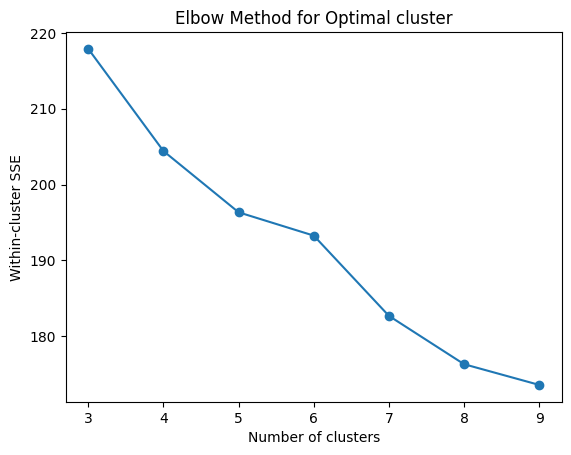

In [17]:
clusterlist = range(3,10)
sse=[]

for k in clusterlist:
    clustering_model = KMeans(n_clusters=k, random_state=42)
    clustering_model.fit(embeddings)
    sse.append(clustering_model.inertia_)

# Plot Elbow Curve
plt.plot(clusterlist, sse, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster SSE")
plt.title("Elbow Method for Optimal cluster")
plt.show()
# for k, sse in zip(list(range(len(sse))),sse):
#   print(k, sse)

Running Kmeans on optimal cluster value of 38 which is the elbow

In [18]:
# k= ~10 for optimal clustering
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

In [19]:
df2['cluster'] = cluster_assignment
df2.head()

,media_id,media_caption,cluster
2,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,3
8857,1091806986322990,My go-to for waking up my skin! 🍊🫧 Click the l...,8
0,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",8
8858,17950254656929862,Why use one scrub when you can use them all at...,0
3,1098364052333950,Why use one scrub when you can use them all at...,1


adding the cluster value to original dataframe

In [20]:
df = df.merge(df2[['media_id','cluster']],how='left',on='media_id')
df['cluster'] = df['cluster'].astype(str)
df.head()

,timestamp,media_id,media_caption,comment_text,timedelta,comment_type,count,comment_wo_mentions,cluster
0,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,NaT,comments,16,Love it,3
1,2025-03-01 00:13:57.032000+00:00,1091806986322990,My go-to for waking up my skin! 🍊🫧 Click the l...,I miss the old line…,NaT,comments,6,I miss the old line…,8
2,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,NaT,comments,6,I bet this is good,8
3,2025-03-01 00:13:57.696000+00:00,17950254656929862,Why use one scrub when you can use them all at...,Noooo,NaT,comments,105,Noooo,0
4,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,0 days 00:09:09.183000,comments,105,i know this smells so good,0


## Sentiment Analysis

Using RoBERTa model to analyse sentiment because its a robust pretrained BERT model optimized for sentiment analysis. BERT also is better at understanding context

In [21]:
#model params
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
label_mapping = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}

In [22]:
from transformers import pipeline

# Load sentiment analysis pipeline

sentiment_classifier = pipeline("sentiment-analysis", model=MODEL)


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Run sentiment analysis on comments without mentions that we have created

In [23]:
# Run sentiment analysis
df3 = list(df['comment_wo_mentions'])
results = sentiment_classifier(df3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [24]:
#Rework on the dataframe with sentiment results
df['sentiment'] = [label_mapping[result['label']] for result in results]
df['sentiment_score'] = [result['score'] for result in results]
df.head()

,timestamp,media_id,media_caption,comment_text,timedelta,comment_type,count,comment_wo_mentions,cluster,sentiment,sentiment_score
0,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,NaT,comments,16,Love it,3,Positive,0.920526
1,2025-03-01 00:13:57.032000+00:00,1091806986322990,My go-to for waking up my skin! 🍊🫧 Click the l...,I miss the old line…,NaT,comments,6,I miss the old line…,8,Neutral,0.588295
2,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,NaT,comments,6,I bet this is good,8,Positive,0.970928
3,2025-03-01 00:13:57.696000+00:00,17950254656929862,Why use one scrub when you can use them all at...,Noooo,NaT,comments,105,Noooo,0,Neutral,0.451720
4,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,0 days 00:09:09.183000,comments,105,i know this smells so good,0,Positive,0.975853


# Results Analysis

Sentiment analysis even though exists for all comments, it mainly pertain to only commnets and commentions (meaning comments with mentions)

In [25]:
df.pivot_table(index='comment_type', columns='sentiment',values='sentiment_score',aggfunc='mean')

sentiment,Negative,Neutral,Positive
comment_type,,,
commentions,0.695235,0.667870,0.853319
comments,0.743327,0.721028,0.869001
mentions,NaN,0.451272,NaN


above data tells that mentions are always neutral.l sentiment analysis is for only the comment text having comments and not mentions only.

###Prepping data for mentions count by media and cluster
### mentions count can be treated as positive as customers are exposing visibility to other users impacting in a positive way

In [26]:
df['mentions_count_bymedia'] = df[df.comment_type.str.contains('mentions')].groupby('media_id',as_index=False)['comment_type'].transform('count')
df['mentions_count_bycluster'] = df[df.comment_type.str.contains('mentions')].groupby('cluster',as_index=False)['comment_type'].transform('count')

df[df.comment_type== 'mentions'].head()


,timestamp,media_id,media_caption,comment_text,timedelta,comment_type,count,comment_wo_mentions,cluster,sentiment,sentiment_score,mentions_count_bymedia,mentions_count_bycluster
11,2025-03-01 01:42:31.207000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@nat_albano26,NaT,mentions,106,,1,Neutral,0.451272,87.0,2526.0
14,2025-03-01 02:10:18.231000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@adbircheat,0 days 00:27:47.024000,mentions,106,,1,Neutral,0.451272,87.0,2526.0
15,2025-03-01 02:12:43.282000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@brittany_lollar,0 days 00:02:25.051000,mentions,106,,1,Neutral,0.451272,87.0,2526.0
18,2025-03-01 02:27:01.167000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@kalwone,0 days 00:14:17.885000,mentions,106,,1,Neutral,0.451272,87.0,2526.0
23,2025-03-01 03:14:00.708000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,'@gg3angels,0 days 00:46:59.541000,mentions,106,,1,Neutral,0.451272,87.0,2526.0


/tmp/ipython-input-27-3520183138.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


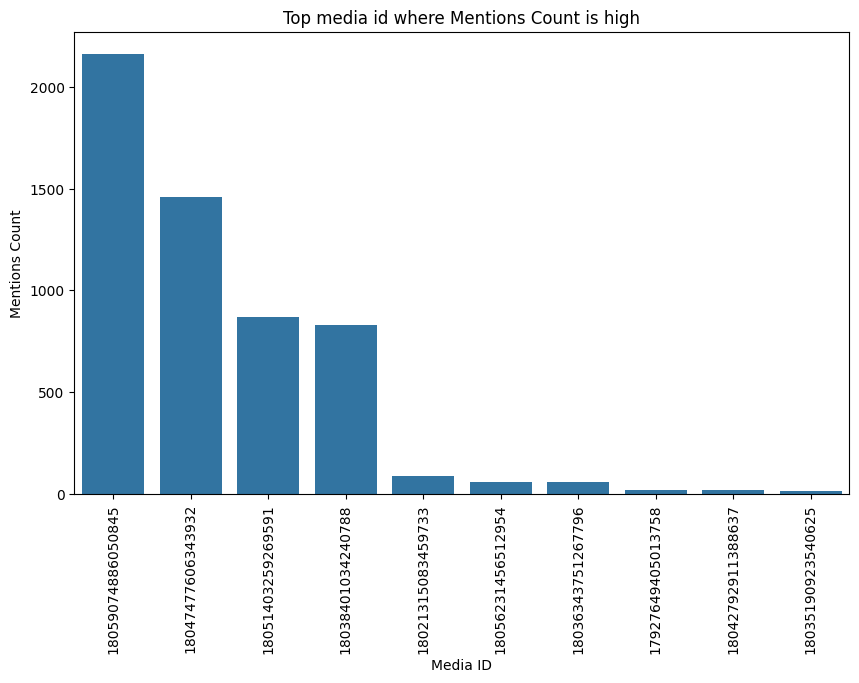

In [27]:
df4 = df[(df.comment_type== 'mentions')&(df.mentions_count_bymedia>10)][['media_id','mentions_count_bymedia']].drop_duplicates()
fig,ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df4,y='mentions_count_bymedia',x='media_id', ax=ax, order=df4.sort_values('mentions_count_bymedia', ascending=False).media_id)
ax.set_xlabel('Media ID')
ax.set_ylabel('Mentions Count')
ax.set_title('Top media id where Mentions Count is high')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Clusters have some indepth meaning based on the text the captions have

cluster                      object
mentions_count_bycluster    float64
dtype: object


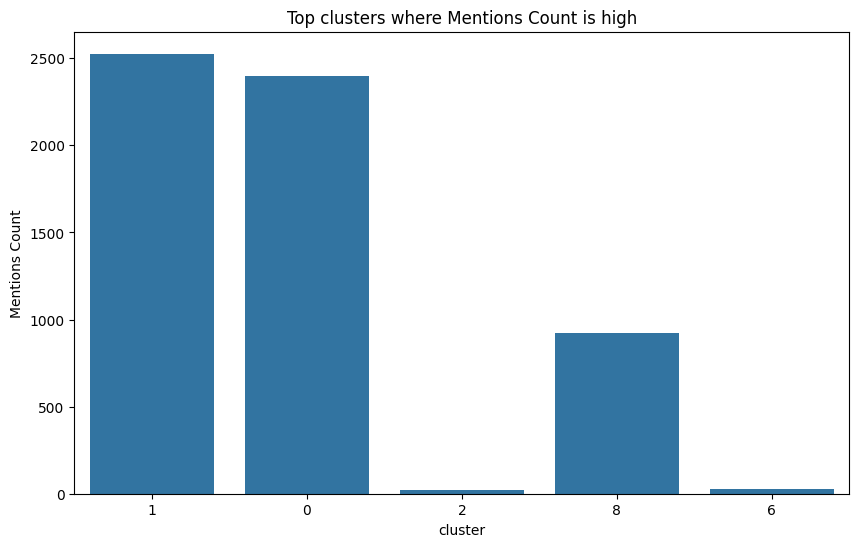

In [28]:
df4 = df[(df.comment_type== 'mentions')&(df.mentions_count_bycluster>10)][['cluster','mentions_count_bycluster']].drop_duplicates()
df4['cluster'] = df4['cluster'].astype(str)
print(df4.dtypes)
fig2,ax2 = plt.subplots(figsize=(10, 6))
sns.barplot(data=df4,y='mentions_count_bycluster', x='cluster', ax=ax2)
ax2.set_xlabel('cluster')
ax2.set_ylabel('Mentions Count')
ax2.set_title('Top clusters where Mentions Count is high')
plt.show()

###sentiment plot by media

In [29]:
def sentiment_bar_plot(col, title, rot=0, sortby='x'):
  sentiment_counts = df.groupby([col, 'sentiment']).size().unstack(fill_value=0)

  if sortby=='x':
    top_ids = df[col].value_counts().head(10).index
    sentiment_counts_subset = sentiment_counts.loc[top_ids]
  else:
    top_ids = sentiment_counts.sort_values(by=sortby,ascending=False).head(10).index
    sentiment_counts_subset = sentiment_counts.loc[top_ids][sortby]

  sentiment_counts_subset.plot(kind='bar', figsize=(15, 7))
  plt.title(f'Sentiment Distribution per {title}')
  plt.xlabel(f'{col}')
  plt.ylabel('Number of Comments')
  plt.xticks(rotation=rot)
  plt.tight_layout()
  plt.show()

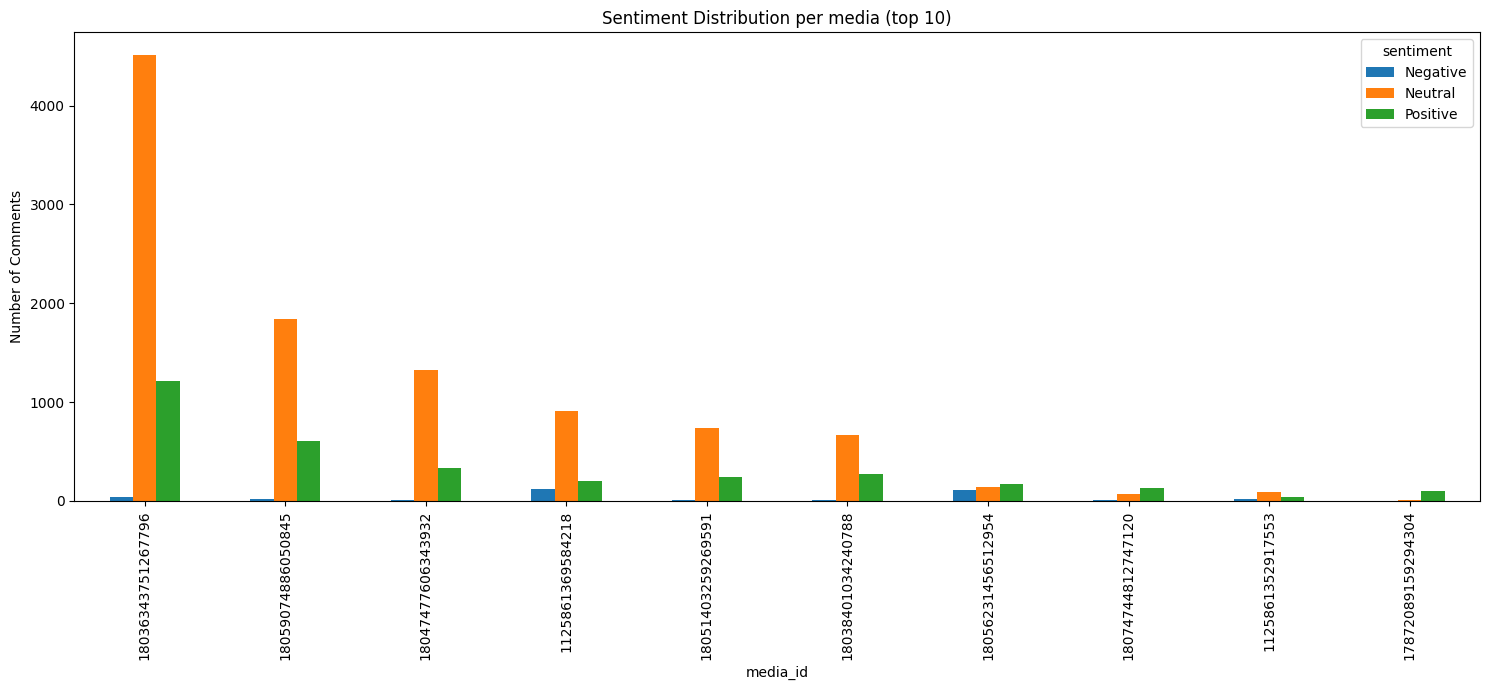

In [30]:

sentiment_bar_plot(col='media_id', title='media (top 10)', rot=90)


###Top negative comments by media

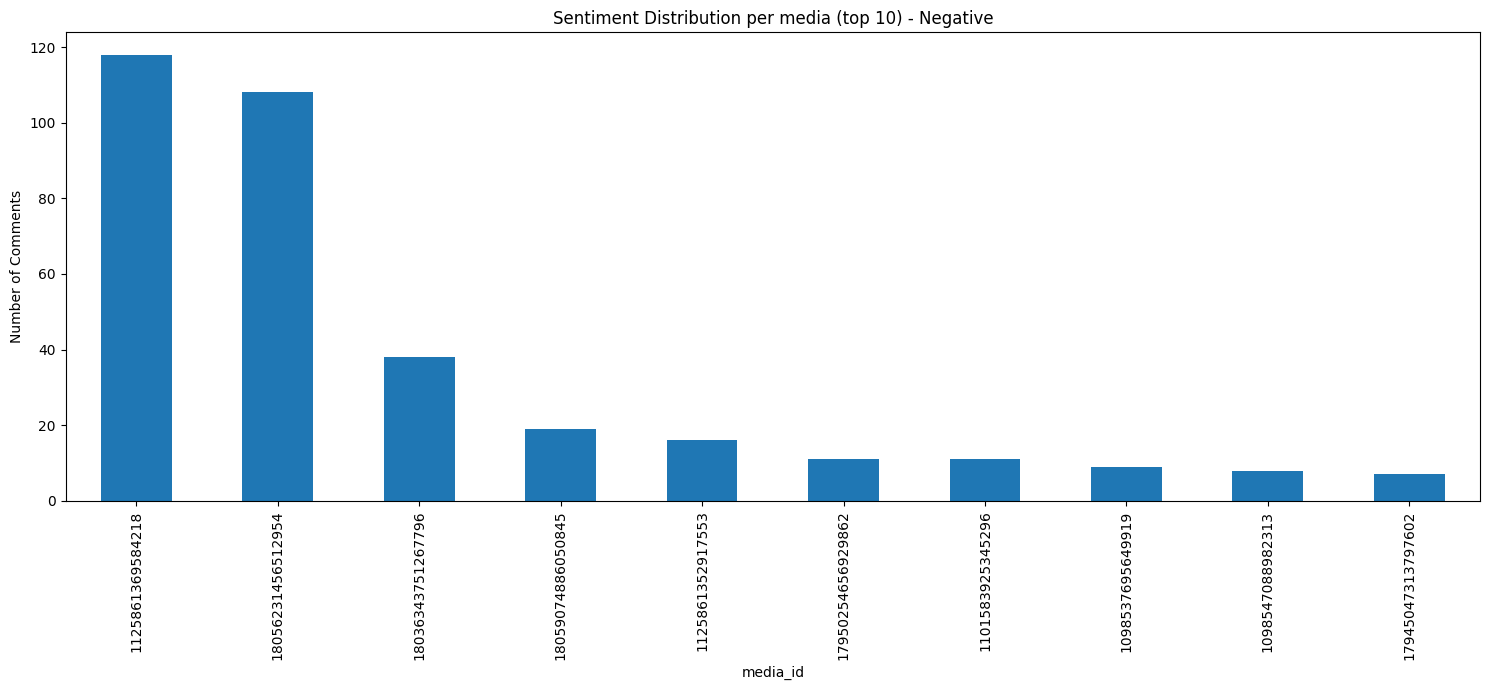

In [31]:
sentiment_bar_plot(col='media_id', title='media (top 10) - Negative', rot=90, sortby='Negative')

###Top comments by cluster

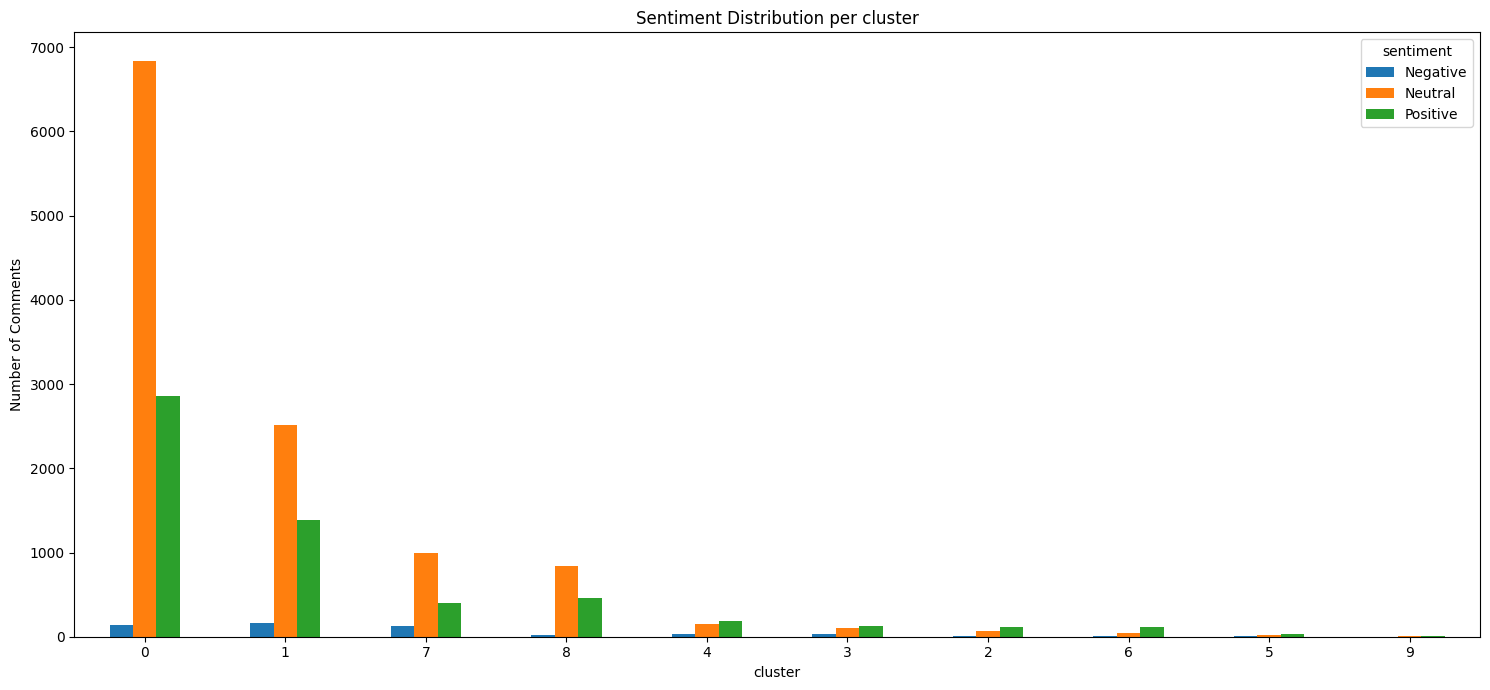

In [32]:
sentiment_bar_plot(col='cluster', title='cluster', rot=0)

###Top negative comment by cluster

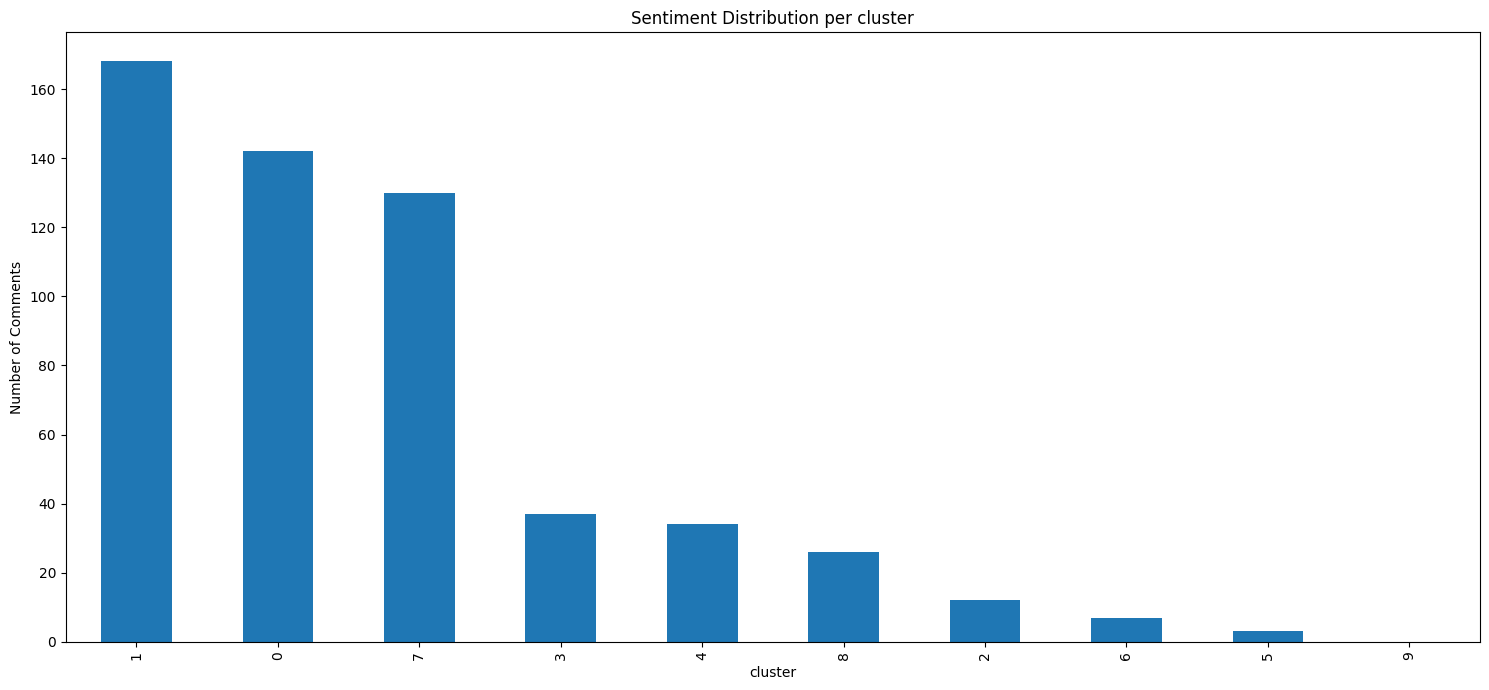

In [33]:
sentiment_bar_plot(col='cluster', title='cluster', rot=90, sortby='Negative')

###SCatter plot of total comments for each media to removing extremeties

No significant conclusion can be obtained from the counts vs sentiment

/tmp/ipython-input-34-2835795866.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


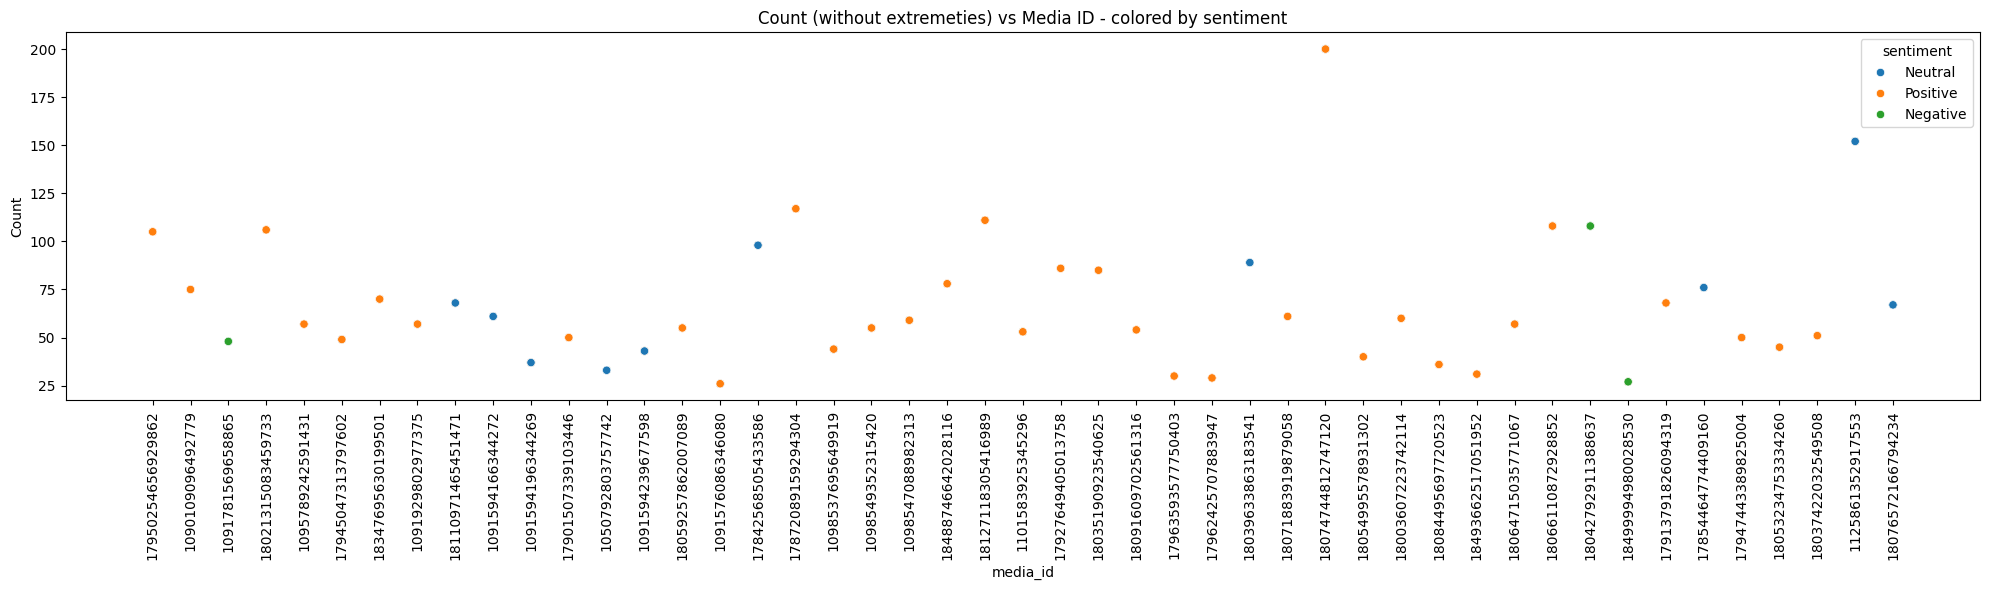

In [34]:
fig, ax = plt.subplots(figsize=(20, 6))
sentiment_df = df[(df.comment_type.str.contains('com'))&(df['count']>25)&(df['count']<250)].copy()
sentiment_df['media_id'] = sentiment_df['media_id'].astype(str)
sentiment_df.head()


sns.scatterplot(data=sentiment_df, x='media_id', y='count', ax=ax, hue='sentiment')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Count')
ax.set_title('Count (without extremeties) vs Media ID - colored by sentiment')
plt.xticks(rotation=90)
# ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Summarization

Summarization model summarizes user comments across different media within positive and negative sentiments. Using BART of flan that has better autoencoder and decoder model for understanding sentiemnt as well as generating the summary

In [35]:
summarizer_model = "facebook/bart-large-cnn"#"facebook/bart-large-cnn" #"google/flan-t5-large"

In [36]:

df[(df['media_id']==17872089159294304)&(df.comment_type.str.contains('com'))&(df.sentiment=='Negative')].shape

(3, 13)

In [37]:
summarizer = pipeline("summarization", model=summarizer_model)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


#####generate summarization for media with more comments: say ones with more than 50 comments

In [38]:
df_summary = df[(df['count']>100)&(df.media_id!=17872089159294304)]

In [39]:

# for m in df_summary['media_id'].unique():
#   print(f'\nmedia: {m}')
#   for s in ['Positive','Negative']:
#     df_tmp = df[(df['media_id']==m)&(df.comment_type.str.contains('com'))&(df.sentiment==s)]
#     if df_tmp.shape[0]<5:
#       continue
#     comments = list(df_tmp['comment_wo_mentions'])
#     comments = [str(i)+". "+c+"\n" for i,c in enumerate(comments)]
#     allcomments = f"Summarize all the following {s} user comments on products: " + " ".join(comments)
#     summary = summarizer(allcomments, max_length=25, min_length=5, do_sample=False)
#     print(f"\t{s} summary: {summary[0]['summary_text']}")
